In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## 데이터셋 확인

In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

from torchvision import transforms
from torch.utils.data import DataLoader
from ipywidgets import interact
from pathlib import Path

In [ ]:
data_dir = '/content/drive/Othercomputers/내 컴퓨터/GitHub/few shot learning/Face-Recognition/'
phase = 'train'

In [ ]:
person_items = []

for (root, dirs, files) in os.walk(os.path.join(data_dir, phase)):
    if len(files) > 0:
        for file_name in files:
            person_items.append(os.path.join(root, file_name))

In [ ]:
len(person_items)

70

In [ ]:
index = 0

faceA_path = person_items[index]

In [ ]:
faceA_path

'/content/drive/Othercomputers/내 컴퓨터/GitHub/few shot learning/Face-Recognition/train/s1/6.png'

In [ ]:
Path(faceA_path).parent

PosixPath('/content/drive/Othercomputers/내 컴퓨터/GitHub/few shot learning/Face-Recognition/train/s1')

In [ ]:
Path(faceA_path).parent.name

's1'

In [ ]:
person = Path(faceA_path).parent.name
same_person_dir = Path(faceA_path).parent

In [ ]:
same_person_images = [fn for fn in os.listdir(same_person_dir) if fn.endswith('png')]

In [ ]:
np.random.choice(same_person_images)

'7.png'

In [ ]:
faceB_path = os.path.join(same_person_dir, np.random.choice(same_person_images))
faceB_path

'/content/drive/Othercomputers/내 컴퓨터/GitHub/few shot learning/Face-Recognition/train/s1/3.png'

In [ ]:
faceA_image = cv2.imread(faceA_path, 0)
faceB_image = cv2.imread(faceB_path, 0)

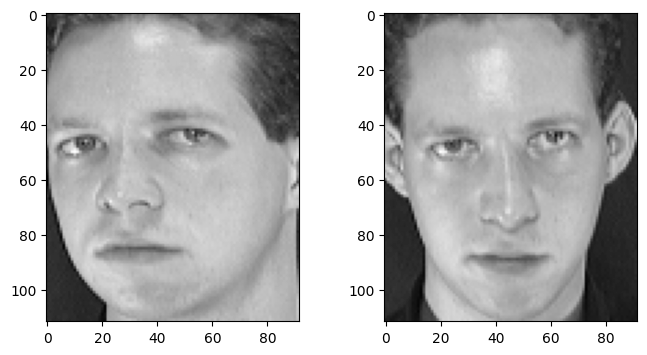

In [ ]:
plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.imshow(faceA_image, cmap='gray')
plt.subplot(122)
plt.imshow(faceB_image, cmap='gray')
plt.show()

In [ ]:
while True:
    faceB_path = np.random.choice(person_items)
    if person != Path(faceB_path).parent.name:
        break

In [ ]:
faceA_image = cv2.imread(faceA_path, 0)
faceB_image = cv2.imread(faceB_path, 0)

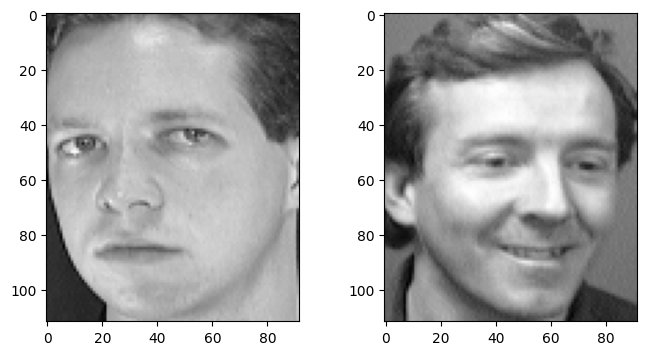

In [ ]:
plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.imshow(faceA_image, cmap='gray')
plt.subplot(122)
plt.imshow(faceB_image, cmap='gray')
plt.show()

## 데이터셋 구축

In [ ]:
class MyDataset():
    def __init__(self, data_dir, phase, transform=None):
        self.person_items = []

        for (root, dirs, files) in os.walk(os.path.join(data_dir, phase)):
            if len(files) > 0:
                for file_name in files:
                    self.person_items.append(os.path.join(root, file_name))

        self.transform = transform

    def __len__(self):
        return len(self.person_items)

    def __getitem__(self, index):
        faceA_path = self.person_items[index]
        person = Path(faceA_path).parent.name

        same_person = np.random.randint(2) # 0, 1 값 중 하나 반환

        if same_person: # 1
            same_person_dir = Path(faceA_path).parent
            same_person_fn = [fn for fn in os.listdir(same_person_dir) if fn.endswith('png')]
            faceB_path = os.path.join(same_person_dir, np.random.choice(same_person_fn))
        else:          # 0
            while True:
                faceB_path = np.random.choice(self.person_items)
                if person != Path(faceB_path).parent.name:
                    break

        faceA_image = cv2.imread(faceA_path, 0)
        faceB_image = cv2.imread(faceB_path, 0)

        if self.transform:
            faceA_image = self.transform(faceA_image)
            faceB_image = self.transform(faceB_image)

        return faceA_image, faceB_image, np.array([1 - same_person]) # labels => 동일 인물 : 0 / 다른 인물 : 1

In [ ]:
trainset = MyDataset(data_dir, 'train')

label:  [1]


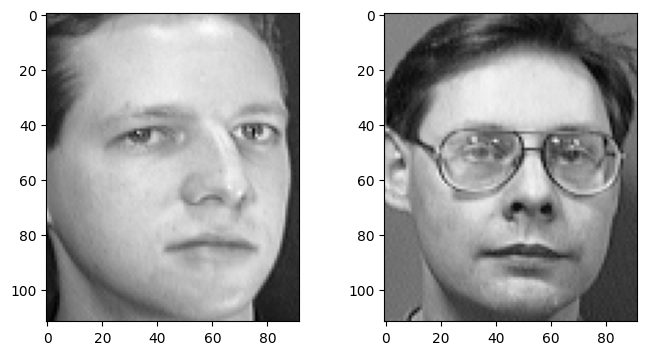

In [ ]:
index = 2
faceA, faceB, label = trainset[index]
print('label: ', label)

plt.figure(figsize=(8, 4))
plt.subplot(121)
plt.imshow(faceA, cmap='gray')
plt.subplot(122)
plt.imshow(faceB, cmap='gray')
plt.show()

In [ ]:
@interact(index = (0, len(trainset)-1))
def show_image(index=0):
    faceA, faceB, label = trainset[index]
    print('label: ', label)

    plt.figure(figsize=(8, 4))
    plt.subplot(121)
    plt.imshow(faceA, cmap='gray')
    plt.subplot(122)
    plt.imshow(faceB, cmap='gray')
    plt.show()

interactive(children=(IntSlider(value=0, description='index', max=69), Output()), _dom_classes=('widget-intera…

In [ ]:
def build_transform(image_size=100):
    transform = {}
    transform['train'] = transforms.Compose([
                                            transforms.ToPILImage(),
                                            transforms.RandomAffine(degrees=5, translate=(0.05, 0.05), scale=(0.9, 1.1)),
                                            transforms.RandomHorizontalFlip(),
                                            transforms.Resize((image_size, image_size)),
                                            transforms.ToTensor(),
                                            transforms.Normalize((0.5), (0.5))
                                            ])

    transform['val'] = transforms.Compose([
                                            transforms.ToPILImage(),
                                            transforms.Resize((image_size, image_size)),
                                            transforms.ToTensor(),
                                            transforms.Normalize((0.5), (0.5))
                                            ])

    return transform

In [ ]:
IMAGE_SIZE = 100
transform = build_transform(image_size=IMAGE_SIZE)

In [ ]:
train_dataset = MyDataset(data_dir=data_dir, phase='train', transform=transform['train'])
val_dataset = MyDataset(data_dir=data_dir, phase='val', transform=transform['val'])

In [ ]:
def build_dataloader(data_dir, batch_size):
    dataloaders = {}

    transform = build_transform(image_size=IMAGE_SIZE)
    train_dataset = MyDataset(data_dir=data_dir, phase='train', transform=transform['train'])
    val_dataset = MyDataset(data_dir=data_dir, phase='val', transform=transform['val'])

    dataloaders['train'] = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    dataloaders['val'] = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    return dataloaders

In [ ]:
BATCH_SIZE = 64
dataloaders = build_dataloader(data_dir=data_dir, batch_size=BATCH_SIZE)
dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x7f7eea5632b0>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x7f7eea44e950>}

In [ ]:
for _ in range(3):
    for phase in ['train', 'val']:
        for index, batch in enumerate(dataloaders[phase]):
            faceA = batch[0]
            faceB = batch[1]
            labels = batch[2]

            if index % 100 == 0:
                print(f'{phase} - {index}/{len(dataloaders[phase])}')

train - 0/2
val - 0/1
train - 0/2
val - 0/1
train - 0/2
val - 0/1


## siamese network 아키텍쳐 구현

In [2]:
def ConvBlock(in_channel, out_channel):
    return nn.Sequential(
        nn.Conv2d(in_channel, out_channel, kernel_size=3, padding=1),
        nn.ReLU(inplace=True),
        nn.BatchNorm2d(out_channel)
    )

In [3]:
class SiameseNetwork(nn.Module):
    def __init__(self, input_channel):
        super().__init__()

        self.features = nn.Sequential(
            ConvBlock(input_channel, 4),
            ConvBlock(4, 8),
            ConvBlock(8, 8),
            nn.Flatten(),
            nn.Linear(8*100*100, 512),
            nn.ReLU(inplace=True),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 10)
        )

    def forward(self, x1, x2):
        z1 = self.features(x1)
        z2 = self.features(x2)
        return z1, z2

In [4]:
IMAGE_SIZE = 100
x1 = torch.randn(1, 1, IMAGE_SIZE, IMAGE_SIZE)
x2 = torch.randn(1, 1, IMAGE_SIZE, IMAGE_SIZE)

model = SiameseNetwork(input_channel=1)

z1, z2 = model(x1, x2)

In [6]:
z1.shape, z2.shape

(torch.Size([1, 10]), torch.Size([1, 10]))